## Phase-1: Data Loading & Structuring

Step-1: Data Ingestion and Initial Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Go to your project folder
%cd /content/drive/MyDrive/multimodal_mammography


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1BPq115f9Nu1zGGIf_pYtngsK8hJDkhdW/multimodal_mammography


In [3]:
import importlib.util

def load_module_from_path(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module


In [4]:
# Load environment setup
env = load_module_from_path("env", "setup/environment.py")
install = load_module_from_path("install", "setup/install_colab.py")
_ = load_module_from_path("imports", "setup/imports.py")  # No functions to call

# Run setup
install.install_dependencies()
env.suppress_warnings()
env.set_seed(42)
device = env.get_device()


🔄 Detected Google Colab environment.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.
📦 Installing required packages...
✅ Dependencies installed.
 Warnings suppressed.
🔁 Seed set to 42
 Using device: cuda


Step-2: Loading Required csvs' and extracting/exploring images

> Add blockquote



In [5]:
# Load the dynamic module
data_loader = load_module_from_path("data_loader", "data/load_data.py")

# Correct CSV paths
metadata_path    = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/metadata.csv"
breast_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/breast-level_annotations.csv"
finding_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/finding_annotations.csv"

# Load and view data
metadata_df, breast_df, finding_df = data_loader.load_mammo_data(
    metadata_path,
    breast_anno_path,
    finding_anno_path,
    verbose=False
)


In [6]:
import pandas as pd
import zipfile
import os

# Paths
FINAL_DF_PATH = "/content/drive/MyDrive/final_df.csv"
ZIP_PATH = "/content/drive/MyDrive/multimodal_mammography/dataset/zipped_folder/birads_sorted_images.zip"
EXTRACT_PATH = "/content/birads_unzipped"

# Load final_df
final_df = pd.read_csv(FINAL_DF_PATH)
print("final_df loaded:", final_df.shape)

# Extract ZIP safely (skip if already extracted)
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
print(" Unzipping complete.")

# Build image_id → path mapping
imageid_to_path = {}

for root, _, files in os.walk(EXTRACT_PATH):
    for file in files:
        if file.lower().endswith(".png"):
            image_id = file.replace(".png", "")
            imageid_to_path[image_id] = os.path.join(root, file)

print(f"Total PNG images mapped: {len(imageid_to_path)}")

# Merge paths into final_df
final_df["image_path"] = final_df["image_id"].map(imageid_to_path)
missing_paths = final_df["image_path"].isna().sum()

print(f" Image paths merged into final_df. Missing paths: {missing_paths}")

#  Preview
display(final_df[['image_id', 'image_path', 'birads']].head())


final_df loaded: (20000, 21)
 Unzipping complete.
Total PNG images mapped: 20000
 Image paths merged into final_df. Missing paths: 0


,image_id,image_path,birads
0,d8125545210c08e1b1793a5af6458ee2,/content/birads_unzipped/birads_2/b8d273e8601f...,2
1,290c658f4e75a3f83ec78a847414297c,/content/birads_unzipped/birads_2/b8d273e8601f...,2
2,cd0fc7bc53ac632a11643ac4cc91002a,/content/birads_unzipped/birads_2/b8d273e8601f...,2
3,71638b1e853799f227492bfb08a01491,/content/birads_unzipped/birads_2/b8d273e8601f...,2
4,dd9ce3288c0773e006a294188aadba8e,/content/birads_unzipped/birads_1/8269f5971eac...,1


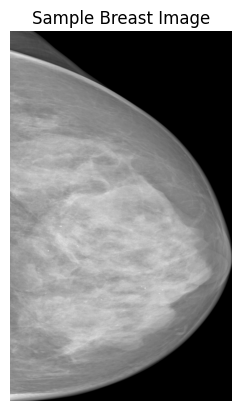

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Pick first valid image path
sample_path = final_df['image_path'].dropna().iloc[0]

# Open and plot
img = Image.open(sample_path)
plt.imshow(img, cmap='gray')
plt.title("Sample Breast Image")
plt.axis('off')
plt.show()


In [8]:
for i in range(1, 6):
    print(f"BI-RADS {i}:")
    !find /content/birads_unzipped/birads_{i} -type f -name "*.png" | head -n 2
    print()


BI-RADS 1:
/content/birads_unzipped/birads_1/40ecd5d8f7e9f7fd4a82606bf8c3e938/06cc99a00e1b1b7a3af374ddf8f9f07f.png
/content/birads_unzipped/birads_1/40ecd5d8f7e9f7fd4a82606bf8c3e938/3c57085013b1286a69aa3f727335fae5.png

BI-RADS 2:
/content/birads_unzipped/birads_2/c8b98ec621e15b34e49608a1afb11b02/699a83869a9021238bfcdb296e6efdf7.png
/content/birads_unzipped/birads_2/c8b98ec621e15b34e49608a1afb11b02/b1efac584a2c752e8aa40915c64700f6.png

BI-RADS 3:
/content/birads_unzipped/birads_3/e3c869c841efa64b702a10a5ec702998/0f3a1f45d84cbe6b77b3e9354bb9ea1a.png
/content/birads_unzipped/birads_3/e3c869c841efa64b702a10a5ec702998/d34a6cfd878c78f803de9defba2569d6.png

BI-RADS 4:
/content/birads_unzipped/birads_4/2c90542f6f10926cde501ebd8de7c3c3/4ae52d114924c90767dfb6ab86ea460d.png
/content/birads_unzipped/birads_4/2c90542f6f10926cde501ebd8de7c3c3/248979f8c341862b99d2ab1e40a4efb1.png

BI-RADS 5:
/content/birads_unzipped/birads_5/a0d75cb5a7be01a0d63f5d9ec553443e/3c315903764b853c05c059346675e1b7.png
/cont

Step-3: Organizing image by folder/study id

In [9]:
import pandas as pd
import os

#  Paths
FINAL_DF_PATH = "/content/drive/MyDrive/final_df.csv"
IMAGE_ROOT = "/content/birads_unzipped"
IMAGE_DF_SAVE_PATH = "/content/drive/MyDrive/image_df.csv"

# Load final_df
final_df = pd.read_csv(FINAL_DF_PATH)
print(f"final_df loaded: {final_df.shape}")

#  Build image_id → path mapping
imageid_to_path = {}
for root, _, files in os.walk(IMAGE_ROOT):
    for file in files:
        if file.lower().endswith(".png"):
            imageid = file.replace(".png", "")
            imageid_to_path[imageid] = os.path.join(root, file)

print(f"Total PNG images mapped: {len(imageid_to_path)}")

#  Update final_df paths → image_df
image_df = final_df.copy()
image_df["image_path"] = image_df["image_id"].map(imageid_to_path)

#  Validate paths
missing_files = image_df["image_path"].isna().sum()
print(f"Missing image files: {missing_files}")

#  Save image_df to Drive
image_df.to_csv(IMAGE_DF_SAVE_PATH, index=False)
print(f"image_df saved to: {IMAGE_DF_SAVE_PATH}")

# 6️⃣ Preview
display(image_df.head())


final_df loaded: (20000, 21)
Total PNG images mapped: 20000
Missing image files: 0
image_df saved to: /content/drive/MyDrive/image_df.csv


,image_id,study_id,image_path,filename,birads,birads_dir,density,laterality,view_position,split,...,finding_birads_clean,xmin,ymin,xmax,ymax,has_bbox,age,birads_binary,birads_cleaned,birads_study_level
0,d8125545210c08e1b1793a5af6458ee2,b8d273e8601f348d3664778dae0e7e0b,/content/birads_unzipped/birads_2/b8d273e8601f...,d8125545210c08e1b1793a5af6458ee2.png,2,birads_2,C,L,CC,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
1,290c658f4e75a3f83ec78a847414297c,b8d273e8601f348d3664778dae0e7e0b,/content/birads_unzipped/birads_2/b8d273e8601f...,290c658f4e75a3f83ec78a847414297c.png,2,birads_2,C,L,MLO,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
2,cd0fc7bc53ac632a11643ac4cc91002a,b8d273e8601f348d3664778dae0e7e0b,/content/birads_unzipped/birads_2/b8d273e8601f...,cd0fc7bc53ac632a11643ac4cc91002a.png,2,birads_2,C,R,CC,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
3,71638b1e853799f227492bfb08a01491,b8d273e8601f348d3664778dae0e7e0b,/content/birads_unzipped/birads_2/b8d273e8601f...,71638b1e853799f227492bfb08a01491.png,2,birads_2,C,R,MLO,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
4,dd9ce3288c0773e006a294188aadba8e,8269f5971eaca3e5d3772d1796e6bd7a,/content/birads_unzipped/birads_1/8269f5971eac...,dd9ce3288c0773e006a294188aadba8e.png,1,birads_1,C,L,CC,training,...,[],NaN,NaN,NaN,NaN,0,42.0,normal,1,1


Step-4: EDA & Statistical Summary

In [10]:
import pandas as pd

# Load image_df
IMAGE_DF_PATH = "/content/drive/MyDrive/image_df.csv"
image_df = pd.read_csv(IMAGE_DF_PATH)
print(f"image_df loaded: {image_df.shape}")

#  Basic Info
print("\n DataFrame Info:")
print(image_df.info())

#  Missing Values
missing_summary = image_df.isnull().sum()
print("\n Missing Values Per Column:")
print(missing_summary[missing_summary > 0])

#  BI-RADS Distribution
birads_counts = image_df['birads'].value_counts().sort_index()
print("\n BI-RADS Distribution:")
print(birads_counts)

# Density Distribution
if 'density' in image_df.columns:
    density_counts = image_df['density'].value_counts()
    print("\n🌫 Density Distribution:")
    print(density_counts)

#  Split Distribution (Training/Validation/Test)
if 'split' in image_df.columns:
    split_counts = image_df['split'].value_counts()
    print("\n Dataset Split Distribution:")
    print(split_counts)

#  Studies per BI-RADS
studies_per_birads = image_df.groupby('birads')['study_id'].nunique()
print("\n Unique Studies per BI-RADS:")
print(studies_per_birads)

#  Images per Study (Summary Stats)
images_per_study = image_df.groupby('study_id')['image_id'].count()
print("\n Images per Study Summary:")
print(images_per_study.describe())

# Bounding Box Stats (if available)
if {'xmin','ymin','xmax','ymax'}.issubset(image_df.columns):
    bbox_count = (image_df[['xmin','ymin','xmax','ymax']].notnull().all(axis=1)).sum()
    print(f"\n Studies with bounding boxes: {bbox_count}/{len(image_df)} images")

# 9️⃣ Save Statistical Report
report_path = "/content/drive/MyDrive/image_df_statistical_report.csv"
stat_report = {
    "total_images": [len(image_df)],
    "unique_studies": [image_df['study_id'].nunique()],
    "birads_distribution": [birads_counts.to_dict()],
    "density_distribution": [density_counts.to_dict() if 'density' in image_df.columns else {}],
    "split_distribution": [split_counts.to_dict() if 'split' in image_df.columns else {}],
    "images_per_study_summary": [images_per_study.describe().to_dict()],
    "missing_values": [missing_summary.to_dict()]
}
pd.DataFrame(stat_report).to_csv(report_path, index=False)
print(f"\n Statistical report saved to: {report_path}")


image_df loaded: (20000, 21)

 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image_id              20000 non-null  object 
 1   study_id              20000 non-null  object 
 2   image_path            20000 non-null  object 
 3   filename              20000 non-null  object 
 4   birads                20000 non-null  int64  
 5   birads_dir            20000 non-null  object 
 6   density               20000 non-null  object 
 7   laterality            20000 non-null  object 
 8   view_position         20000 non-null  object 
 9   split                 20000 non-null  object 
 10  finding_categories    20000 non-null  object 
 11  finding_birads_clean  20000 non-null  object 
 12  xmin                  1768 non-null   float64
 13  ymin                  1768 non-null   float64
 14  xmax                  1

In [11]:
import pandas as pd

# Load image_df
IMAGE_DF_PATH = "/content/drive/MyDrive/image_df.csv"
image_df = pd.read_csv(IMAGE_DF_PATH)
print(f"image_df loaded: {image_df.shape}")

# Group by study_id
study_df = image_df.groupby("study_id").agg({
    "image_id": list,             # All image IDs for this study
    "image_path": list,           # All image paths for this study
    "birads_study_level": "max",  # Study-level label: highest BI-RADS
    "age": "first",               # Age per study (assume same for all images)
    "density": "first",           # Breast density
    "laterality": lambda x: list(x),  # Keep L/R info per image
    "view_position": lambda x: list(x),  # Keep view positions per image
    "has_bbox": lambda x: list(x)       # BBox presence per image
}).reset_index()

# Preview
display(study_df.head())

# Save study-level DataFrame
STUDY_DF_PATH = "/content/drive/MyDrive/study_df.csv"
study_df.to_csv(STUDY_DF_PATH, index=False)
print(f"study_df saved to: {STUDY_DF_PATH}")


image_df loaded: (20000, 21)


,study_id,image_id,image_path,birads_study_level,age,density,laterality,view_position,has_bbox
0,0025a5dc99fd5c742026f0b2b030d3e9,"[451562831387e2822923204cf8f0873e, 2ddfad7286c...",[/content/birads_unzipped/birads_1/0025a5dc99f...,1,44.0,C,"[L, L, R, R]","[CC, MLO, CC, MLO]","[0, 0, 0, 0]"
1,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,"[3704f91985dcbc69f6ac2803523d1ecb, 7fc1f1bb8bb...",[/content/birads_unzipped/birads_2/0028fb2c7f0...,2,51.0,C,"[L, L, R, R]","[CC, MLO, CC, MLO]","[0, 0, 0, 0]"
2,0034765af074f93ed33d5e8399355caf,"[68f09c18925a66ef2840d4a62f237b31, b664cf1e7c9...",[/content/birads_unzipped/birads_2/0034765af07...,2,37.0,C,"[L, L, R, R]","[CC, MLO, CC, MLO]","[0, 0, 0, 0]"
3,003700f3c960e0b9bca2b8437c3dbf05,"[51b47f9024ccad1356354f56ac916f29, 3944b33b99c...",[/content/birads_unzipped/birads_4/003700f3c96...,4,44.0,C,"[L, L, R, R]","[CC, MLO, CC, MLO]","[1, 1, 0, 0]"
4,004426a40da27ef22a866538b772ac44,"[78b8a2f4b10790d6b2a11e081eaf209a, d3ae4a0aa59...",[/content/birads_unzipped/birads_1/004426a40da...,1,50.0,B,"[L, L, R, R]","[CC, MLO, CC, MLO]","[0, 0, 0, 0]"


study_df saved to: /content/drive/MyDrive/study_df.csv


 Step-5: Data Quality Checks & Cleaning

In [13]:
study_unique_counts = image_df.groupby('study_id')['image_id'].nunique()
incomplete_studies = study_unique_counts[study_unique_counts != 4]

print(f"Incomplete studies: {len(incomplete_studies)}")
display(incomplete_studies.head())


Incomplete studies: 0


,image_id
study_id,


In [14]:
import os

missing_files = [p for p in image_df['image_path'] if not os.path.exists(p)]
print(f"Missing image files: {len(missing_files)}")


Missing image files: 0


In [15]:
print(" Unique BI-RADS:", image_df['birads'].unique())
print(" Unique Density:", image_df['density'].unique())


 Unique BI-RADS: [2 1 3 4 5]
 Unique Density: ['C' 'B' 'D' 'A']


In [16]:
bbox_errors = image_df[
    (image_df['has_bbox'] == 1) &
    ((image_df['xmin'] > image_df['xmax']) | (image_df['ymin'] > image_df['ymax']))
]
print(f" Bounding box errors: {len(bbox_errors)}")


 Bounding box errors: 0


In [17]:
import pandas as pd

# Assuming image_df is already loaded
print(f" Original rows: {len(image_df)}")

#  Identify implausible ages
invalid_age_mask = (image_df['age'] < 20) | (image_df['age'] > 90)
invalid_ages_df = image_df[invalid_age_mask]

print(f"Implausible ages found: {invalid_age_mask.sum()}")
print(invalid_ages_df[['image_id', 'study_id', 'birads', 'age']].head())

#  Compute median age per BI-RADS class
birads_median_age = image_df[~invalid_age_mask].groupby('birads')['age'].median()
print("\n Median Age per BI-RADS Class:")
print(birads_median_age)

# Impute invalid ages with BI-RADS median
image_df.loc[invalid_age_mask, 'age'] = image_df.loc[invalid_age_mask, 'birads'].map(birads_median_age)

#  Sanity check after imputation
invalid_age_mask_after = (image_df['age'] < 20) | (image_df['age'] > 90)
print(f"\ Implausible ages after cleaning: {invalid_age_mask_after.sum()}")

#  Save cleaned dataframe
cleaned_path = "/content/drive/MyDrive/image_df_age_cleaned.csv"
image_df.to_csv(cleaned_path, index=False)
print(f" Cleaned image_df saved to: {cleaned_path}")


 Original rows: 20000
Implausible ages found: 528
                              image_id                          study_id  \
1260  4364fdcfaf47fee38a2fd515236a0618  788eeb3a71ff18772afffbab5aa28ee2   
1261  3cd448d134b570ed809559420b36774d  788eeb3a71ff18772afffbab5aa28ee2   
1262  cbd479685f2ba22bca1c787e483dd4af  788eeb3a71ff18772afffbab5aa28ee2   
1263  d9e2f97a5d7172eb944dda6f3ae1a2b8  788eeb3a71ff18772afffbab5aa28ee2   
5120  7fd3de2c70eee253f174fa32758b7f8c  4c4b2aae9062c2fdb7a2bbdf48dc093e   

      birads   age  
1260       1  14.0  
1261       1  14.0  
1262       1  14.0  
1263       1  14.0  
5120       1  18.0  

 Median Age per BI-RADS Class:
birads
1    45.0
2    45.0
3    45.0
4    45.0
5    56.0
Name: age, dtype: float64
\ Implausible ages after cleaning: 0
 Cleaned image_df saved to: /content/drive/MyDrive/image_df_age_cleaned.csv


In [18]:
invalid_ages = image_df[(image_df['age'] < 20) | (image_df['age'] > 90)]
print(f"Implausible ages: {len(invalid_ages)}")


Implausible ages: 0


In [19]:
print(" Duplicate image_ids:", image_df['image_id'].duplicated().sum())
print(" Duplicate image_paths:", image_df['image_path'].duplicated().sum())


 Duplicate image_ids: 0
 Duplicate image_paths: 0


In [20]:
overlap_studies = set(image_df[image_df['split']=='training']['study_id']) & \
                  set(image_df[image_df['split']=='test']['study_id'])
print(f" Study leakage across splits: {len(overlap_studies)}")


 Study leakage across splits: 0


In [21]:
print(image_df.columns)

Index(['image_id', 'study_id', 'image_path', 'filename', 'birads',
       'birads_dir', 'density', 'laterality', 'view_position', 'split',
       'finding_categories', 'finding_birads_clean', 'xmin', 'ymin', 'xmax',
       'ymax', 'has_bbox', 'age', 'birads_binary', 'birads_cleaned',
       'birads_study_level'],
      dtype='object')


In [22]:
import pandas as pd

#  Load cleaned image_df
image_df = pd.read_csv("/content/drive/MyDrive/image_df_age_cleaned.csv")

# ---------------------------------------------------
#  View Position Validation per Study (L-CC, L-MLO, R-CC, R-MLO)
# ---------------------------------------------------
expected_views = {'L-CC', 'L-MLO', 'R-CC', 'R-MLO'}

# Group by study and collect views
view_check = image_df.groupby('study_id').apply(
    lambda x: set(x['laterality'] + '-' + x['view_position'])
)

invalid_view_studies = view_check[view_check != expected_views]
print(f"\n Studies with missing/extra views: {len(invalid_view_studies)}")
if len(invalid_view_studies) > 0:
    print(invalid_view_studies.head())

# ---------------------------------------------------
#   BI-RADS Class Imbalance Report
# ---------------------------------------------------
birads_counts = image_df['birads'].value_counts().sort_index()
birads_binary_counts = image_df['birads_binary'].value_counts()

print("\n BI-RADS Distribution:")
print(birads_counts)

print("\n Normal vs Abnormal Distribution:")
print(birads_binary_counts)

# ---------------------------------------------------
# Metadata Consistency: Check age consistency across each study
# ---------------------------------------------------
age_check = image_df.groupby('study_id')['age'].nunique()
inconsistent_ages = age_check[age_check > 1]

print(f"\nStudies with inconsistent ages: {len(inconsistent_ages)}")
if len(inconsistent_ages) > 0:
    print(image_df[image_df['study_id'].isin(inconsistent_ages.index)][['study_id', 'image_id', 'age']].sort_values('study_id').head())




 Studies with missing/extra views: 1
study_id
dbca9d28baa3207b3187c4d07dc81a80    {R-CC, L-CC, R-MLO}
dtype: object

 BI-RADS Distribution:
birads
1    13406
2     4676
3      930
4      762
5      226
Name: count, dtype: int64

 Normal vs Abnormal Distribution:
birads_binary
normal      18082
abnormal     1918
Name: count, dtype: int64

Studies with inconsistent ages: 20
                               study_id                          image_id  \
15416  01c3c13f0b852aed00b5147c21d0e649  81bf78c982ca444852fa95af7d96429c   
15417  01c3c13f0b852aed00b5147c21d0e649  03b3656c726cbe0d79c86a25d4296559   
15418  01c3c13f0b852aed00b5147c21d0e649  40a196059322084cbce62642c216b215   
15419  01c3c13f0b852aed00b5147c21d0e649  8c7e6e033f0be620335d5287f9396838   
15338  0246c6050121c176d2e8fcf91f22f926  1dfccf26f76424a9eaf4ea6b7cb27f72   

        age  
15416  56.0  
15417  56.0  
15418  45.0  
15419  45.0  
15338  45.0  


In [23]:
import pandas as pd

# Load cleaned image_df
image_df = pd.read_csv("/content/drive/MyDrive/image_df_age_cleaned.csv")

#  Drop study with missing/extra views
invalid_view_study = 'dbca9d28baa3207b3187c4d07dc81a80'
image_df = image_df[image_df['study_id'] != invalid_view_study]
print(f" Dropped study with missing/extra views: {invalid_view_study}")

#  Standardize ages within each study (take median)
age_median_per_study = image_df.groupby('study_id')['age'].median()
image_df['age'] = image_df['study_id'].map(age_median_per_study)

#  Verify no more inconsistencies
age_check = image_df.groupby('study_id')['age'].nunique()
inconsistent_ages = age_check[age_check > 1]
print(f" Studies with inconsistent ages after fixing: {len(inconsistent_ages)}")

#  Save final cleaned dataframe
final_clean_path = "/content/drive/MyDrive/image_df_final_cleaned.csv"
image_df.to_csv(final_clean_path, index=False)
print(f"Final cleaned image_df saved to: {final_clean_path}")


 Dropped study with missing/extra views: dbca9d28baa3207b3187c4d07dc81a80
 Studies with inconsistent ages after fixing: 0
Final cleaned image_df saved to: /content/drive/MyDrive/image_df_final_cleaned.csv


In [24]:
import pandas as pd

# Load cleaned image_df

#  Drop studies that don't have exactly 4 images
study_image_counts = image_df.groupby('study_id')['image_id'].count()
valid_studies = study_image_counts[study_image_counts == 4].index
image_df = image_df[image_df['study_id'].isin(valid_studies)]
print(f" Studies with exactly 4 images retained: {len(valid_studies)}")

#  Fix inconsistent ages by median age per study
study_median_age = image_df.groupby('study_id')['age'].median()
image_df['age'] = image_df['study_id'].map(study_median_age)
print(" Age inconsistency across studies resolved using median age.")

#  Save final cleaned image_df
CLEANED_PATH = "/content/drive/MyDrive/image_df_final_cleaned.csv"
image_df.to_csv(CLEANED_PATH, index=False)
print(f" Final cleaned image_df saved to: {CLEANED_PATH}")


 Studies with exactly 4 images retained: 4999
 Age inconsistency across studies resolved using median age.
 Final cleaned image_df saved to: /content/drive/MyDrive/image_df_final_cleaned.csv


### Rearranging Folders

In [25]:
import pandas as pd
import os
import shutil

# Paths
image_df_path = "/content/drive/MyDrive/image_df_final_cleaned.csv"
output_root = "/content/breast_unprocessed_dataset"
normal_folder = os.path.join(output_root, "normal_unprocessed_dataset")
abnormal_folder = os.path.join(output_root, "abnormal_unprocessed_dataset")

# Load cleaned image_df
image_df = pd.read_csv(image_df_path)


In [26]:
# Study-level BI-RADS is already in 'birads_study_level'
negative_studies = image_df[image_df['birads_study_level'].isin([1, 2, 3])]['study_id'].unique()
positive_studies = image_df[image_df['birads_study_level'].isin([4, 5])]['study_id'].unique()

print(f"Negative studies (BI-RADS 1-3): {len(negative_studies)}")
print(f"Positive studies (BI-RADS 4-5): {len(positive_studies)}")


Negative studies (BI-RADS 1-3): 4518
Positive studies (BI-RADS 4-5): 481


In [27]:
os.makedirs(normal_folder, exist_ok=True)
os.makedirs(abnormal_folder, exist_ok=True)


In [28]:
# Function to copy studies into subfolders
def organize_studies(study_ids, target_root):
    for study_id in study_ids:
        study_images = image_df[image_df['study_id'] == study_id]
        # All images must exist
        if study_images['image_path'].isna().any():
            print(f"⚠ Warning: Missing images in study {study_id}")
            continue
        # Create study folder
        study_folder = os.path.join(target_root, study_id)
        os.makedirs(study_folder, exist_ok=True)
        # Copy images into study folder
        for img_path in study_images['image_path']:
            shutil.copy(img_path, study_folder)

# Organize negative (normal) studies
organize_studies(negative_studies, normal_folder)

# Organize positive (abnormal) studies
organize_studies(positive_studies, abnormal_folder)

print(" Folder reorganization complete!")


 Folder reorganization complete!


In [29]:
import pandas as pd
import os
import shutil

# Paths
image_df_path = "/content/drive/MyDrive/image_df_final_cleaned.csv"
output_root = "/content/breast_unprocessed_dataset"
normal_folder = os.path.join(output_root, "normal_unprocessed_dataset")
abnormal_folder = os.path.join(output_root, "abnormal_unprocessed_dataset")
summary_csv_path = "/content/drive/MyDrive/study_folder_summary.csv"

# Load cleaned image_df
image_df = pd.read_csv(image_df_path)

# Define negative vs positive studies
negative_studies = image_df[image_df['birads_study_level'].isin([1, 2, 3])]['study_id'].unique()
positive_studies = image_df[image_df['birads_study_level'].isin([4, 5])]['study_id'].unique()

# Create folder structure
os.makedirs(normal_folder, exist_ok=True)
os.makedirs(abnormal_folder, exist_ok=True)

# Prepare summary
summary_records = []

# Function to copy studies into subfolders and track summary
def organize_studies(study_ids, target_root, label):
    for study_id in study_ids:
        study_images = image_df[image_df['study_id'] == study_id]
        # Check for missing images
        missing_images = study_images['image_path'].isna().sum()
        if missing_images > 0:
            print(f"⚠ Warning: {missing_images} missing images in study {study_id}")
            continue
        # Create study folder
        study_folder = os.path.join(target_root, study_id)
        os.makedirs(study_folder, exist_ok=True)
        # Copy images
        for img_path in study_images['image_path']:
            shutil.copy(img_path, study_folder)
        # Record summary
        summary_records.append({
            "study_id": study_id,
            "label": label,
            "num_images": len(study_images),
            "target_folder": study_folder
        })

# Organize negative (normal) studies
organize_studies(negative_studies, normal_folder, "negative")

# Organize positive (abnormal) studies
organize_studies(positive_studies, abnormal_folder, "positive")

# Save summary CSV
summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(summary_csv_path, index=False)

print(" Folder reorganization complete!")
print(f"Summary CSV saved to: {summary_csv_path}")


 Folder reorganization complete!
Summary CSV saved to: /content/drive/MyDrive/study_folder_summary.csv


In [30]:
import os
import pandas as pd

# Load image_df
image_df_path = "/content/drive/MyDrive/image_df_final_cleaned.csv"
image_df = pd.read_csv(image_df_path)

# Paths
normal_folder = "/content/breast_unprocessed_dataset/normal_unprocessed_dataset"
abnormal_folder = "/content/breast_unprocessed_dataset/abnormal_unprocessed_dataset"

# Function to validate studies in a folder
def validate_folder(folder_path, label):
    errors = []
    for study_id in os.listdir(folder_path):
        study_path = os.path.join(folder_path, study_id)
        if not os.path.isdir(study_path):
            continue
        expected_count = len(image_df[image_df['study_id']==study_id])
        actual_count = len([f for f in os.listdir(study_path) if f.lower().endswith(".png")])
        if expected_count != actual_count:
            errors.append({
                "study_id": study_id,
                "label": label,
                "expected_images": expected_count,
                "actual_images": actual_count
            })
    return errors

# Validate normal and abnormal folders
normal_errors = validate_folder(normal_folder, "negative")
abnormal_errors = validate_folder(abnormal_folder, "positive")

all_errors = normal_errors + abnormal_errors
if all_errors:
    print(f"⚠ Found {len(all_errors)} inconsistencies!")
    display(pd.DataFrame(all_errors))
else:
    print("All study folders validated successfully with image_df!")


All study folders validated successfully with image_df!


In [31]:
import shutil

# Paths
dataset_folder = "/content/breast_unprocessed_dataset"
zip_path = "/content/breast_unprocessed_dataset.zip"

# Create zip
shutil.make_archive(zip_path.replace(".zip",""), 'zip', dataset_folder)
print(f" Dataset zipped at {zip_path}")


 Dataset zipped at /content/breast_unprocessed_dataset.zip


In [32]:
import shutil
import os

# Paths
dataset_folder = "/content/breast_unprocessed_dataset"
zip_name = "breast_unprocessed_dataset.zip"
zip_path = f"/content/{zip_name}"
drive_path = f"/content/drive/MyDrive/{zip_name}"

#  Create zip archive
shutil.make_archive(base_name=zip_path.replace(".zip",""), format='zip', root_dir=dataset_folder)
print(f" Dataset zipped at {zip_path}")

#  Move zip to Google Drive
shutil.move(zip_path, drive_path)
print(f" Zip moved to Google Drive at: {drive_path}")


 Dataset zipped at /content/breast_unprocessed_dataset.zip
 Zip moved to Google Drive at: /content/drive/MyDrive/breast_unprocessed_dataset.zip


In [33]:
print(image_df.columns)

Index(['image_id', 'study_id', 'image_path', 'filename', 'birads',
       'birads_dir', 'density', 'laterality', 'view_position', 'split',
       'finding_categories', 'finding_birads_clean', 'xmin', 'ymin', 'xmax',
       'ymax', 'has_bbox', 'age', 'birads_binary', 'birads_cleaned',
       'birads_study_level'],
      dtype='object')


In [34]:
import pandas as pd
import os

# Load cleaned image_df
image_df = pd.read_csv("/content/drive/MyDrive/image_df_age_cleaned.csv")

# Map BI-RADS to folder
def map_to_new_path(row, base_folder="/content/breast_unprocessed_dataset"):
    if row['birads'] <= 3:
        folder = "normal_unprocessed_dataset"
    else:
        folder = "abnormal_unprocessed_dataset"

    # Study folder
    study_folder = row['study_id']
    image_file = row['filename']

    # Full path
    return os.path.join(base_folder, folder, study_folder, image_file)

# Apply mapping
image_df['image_path'] = image_df.apply(map_to_new_path, axis=1)

# Optional: check that all paths exist
missing_paths = image_df[~image_df['image_path'].apply(os.path.exists)]
print(f"Missing images: {len(missing_paths)}")  # Should be 0


Missing images: 940


In [35]:
import os

base_folder = "/content/breast_unprocessed_dataset"
study_count = 0
image_count = 0

# Iterate over normal and abnormal subfolders
for subfolder in ["normal_unprocessed_dataset", "abnormal_unprocessed_dataset"]:
    subfolder_path = os.path.join(base_folder, subfolder)

    if os.path.exists(subfolder_path):
        # Each folder in subfolder_path is a study
        for study_folder in os.listdir(subfolder_path):
            study_path = os.path.join(subfolder_path, study_folder)
            if os.path.isdir(study_path):
                study_count += 1
                # Count PNG images in this study
                image_count += len([f for f in os.listdir(study_path) if f.lower().endswith(".png")])

print(f"Total studies: {study_count}")
print(f"Total images: {image_count}")


Total studies: 4999
Total images: 19996


In [36]:
import pandas as pd

# Load your ready image_df (after missing images filtered, if applicable)

# Count unique studies
total_studies = image_df['study_id'].nunique()

# Count total images
total_images = len(image_df)

print(f"Total studies in image_df: {total_studies}")
print(f"Total images in image_df: {total_images}")


Total studies in image_df: 5000
Total images in image_df: 20000


In [37]:
import os
import shutil
import pandas as pd

# -----------------------------
#  Paths
# -----------------------------
base_folder = "/content/breast_unprocessed_dataset"
zip_output_path = "/content/drive/MyDrive/breast_unprocessed_dataset.zip"
image_df_path = "/content/drive/MyDrive/image_df_ready.csv"

# -----------------------------
#  Zip the entire dataset
# -----------------------------
# Remove existing zip if it exists
if os.path.exists(zip_output_path):
    os.remove(zip_output_path)

shutil.make_archive(zip_output_path.replace('.zip',''), 'zip', base_folder)
print(f" Dataset zipped to: {zip_output_path}")




 Dataset zipped to: /content/drive/MyDrive/breast_unprocessed_dataset.zip


In [38]:


# -----------------------------
#  Validate studies & images in the folder
# -----------------------------
existing_studies = set()
for subfolder in ["normal_unprocessed_dataset", "abnormal_unprocessed_dataset"]:
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.exists(subfolder_path):
        for study_folder in os.listdir(subfolder_path):
            study_path = os.path.join(subfolder_path, study_folder)
            if os.path.isdir(study_path):
                existing_studies.add(study_folder)

# Compare with image_df
all_studies_df = set(image_df['study_id'].unique())
missing_studies = all_studies_df - existing_studies
extra_studies = existing_studies - all_studies_df

print(f"Missing studies (in image_df but not in folder): {len(missing_studies)}")
print(f"Extra studies (in folder but not in image_df): {len(extra_studies)}")

# -----------------------------
#  Count images
# -----------------------------
total_images_in_folder = sum(len(files)
                             for root, _, files in os.walk(base_folder)
                             for file in files if file.lower().endswith(".png"))

print(f"Total studies in folder: {len(existing_studies)}")
print(f" Total images in folder: {total_images_in_folder}")

Missing studies (in image_df but not in folder): 1
Extra studies (in folder but not in image_df): 0
Total studies in folder: 4999
 Total images in folder: 79984


In [39]:
import os

FOLDER_ROOT = "/content/breast_unprocessed_dataset"

folder_studies = [d for d in os.listdir(FOLDER_ROOT) if os.path.isdir(os.path.join(FOLDER_ROOT, d))]
folder_studies_set = set(folder_studies)
print(f" Total studies in folder: {len(folder_studies_set)}")


 Total studies in folder: 2


In [40]:
import pandas as pd


df_studies_set = set(image_df['study_id'].unique())
print(f" Total studies in image_df: {len(df_studies_set)}")


 Total studies in image_df: 5000


In [41]:
missing_in_folder = df_studies_set - folder_studies_set
extra_in_folder   = folder_studies_set - df_studies_set

print(f"Missing studies in folder: {len(missing_in_folder)}")
print(f"Extra studies in folder: {len(extra_in_folder)}")


Missing studies in folder: 5000
Extra studies in folder: 2


In [42]:
import os
import pandas as pd

# -----------------------------
# Paths
# -----------------------------
BASE_FOLDER = "/content/breast_unprocessed_dataset"
NORMAL_FOLDER = os.path.join(BASE_FOLDER, "normal_unprocessed_dataset")
ABNORMAL_FOLDER = os.path.join(BASE_FOLDER, "abnormal_unprocessed_dataset")

# -----------------------------

# -----------------------------
# Helper function to collect studies & images
# -----------------------------
def collect_studies_images(root_folder):
    studies = {}
    for study_id in os.listdir(root_folder):
        study_path = os.path.join(root_folder, study_id)
        if os.path.isdir(study_path):
            images = [
                os.path.join(study_path, f)
                for f in os.listdir(study_path)
                if f.lower().endswith(".png")
            ]
            studies[study_id] = images
    return studies

# -----------------------------
# Collect normal and abnormal
# -----------------------------
normal_studies = collect_studies_images(NORMAL_FOLDER)
abnormal_studies = collect_studies_images(ABNORMAL_FOLDER)

all_studies_in_folder = {**normal_studies, **abnormal_studies}

# -----------------------------
# Counts
# -----------------------------
total_studies = len(all_studies_in_folder)
total_images = sum(len(v) for v in all_studies_in_folder.values())

print(f" Total studies in folder: {total_studies}")
print(f" Total images in folder: {total_images}")

# -----------------------------
# Validation against image_df
# -----------------------------
folder_study_ids = set(all_studies_in_folder.keys())
df_study_ids = set(image_df['study_id'].unique())

missing_studies = df_study_ids - folder_study_ids
extra_studies = folder_study_ids - df_study_ids

print(f"Missing studies (in image_df but not in folder): {len(missing_studies)}")
print(f"Extra studies (in folder but not in image_df): {len(extra_studies)}")


 Total studies in folder: 4999
 Total images in folder: 19996
Missing studies (in image_df but not in folder): 1
Extra studies (in folder but not in image_df): 0


In [43]:
missing_study_id = list(df_study_ids - folder_study_ids)
print(" Missing study ID:", missing_study_id)
missing_images = image_df[image_df['study_id'].isin(missing_study_id)]
display(missing_images)


 Missing study ID: ['dbca9d28baa3207b3187c4d07dc81a80']


,image_id,study_id,image_path,filename,birads,birads_dir,density,laterality,view_position,split,...,finding_birads_clean,xmin,ymin,xmax,ymax,has_bbox,age,birads_binary,birads_cleaned,birads_study_level
9512,43aa7523b0fef1c21c20ebddb91ddbff,dbca9d28baa3207b3187c4d07dc81a80,/content/breast_unprocessed_dataset/normal_unp...,43aa7523b0fef1c21c20ebddb91ddbff.png,2,birads_2,C,L,CC,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
9513,266c3602c96a1daff8cbcd2f0493a7f0,dbca9d28baa3207b3187c4d07dc81a80,/content/breast_unprocessed_dataset/normal_unp...,266c3602c96a1daff8cbcd2f0493a7f0.png,2,birads_2,C,L,CC,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,2,2
9514,0510873ed4154bff9feba071c707944f,dbca9d28baa3207b3187c4d07dc81a80,/content/breast_unprocessed_dataset/normal_unp...,0510873ed4154bff9feba071c707944f.png,1,birads_1,C,R,CC,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,1,2
9515,67cb2ebe11727da825907f50a6f9e892,dbca9d28baa3207b3187c4d07dc81a80,/content/breast_unprocessed_dataset/normal_unp...,67cb2ebe11727da825907f50a6f9e892.png,1,birads_1,C,R,MLO,training,...,[],NaN,NaN,NaN,NaN,0,53.0,normal,1,2


In [44]:
import pandas as pd



# ID of the missing study
missing_study_id = "dbca9d28baa3207b3187c4d07dc81a80"

# Drop all rows belonging to that study
image_df = image_df[image_df['study_id'] != missing_study_id]


print(f" Dropped missing study ({missing_study_id}) and saved cleaned image_df.")
print(f" Total studies now: {image_df['study_id'].nunique()}")
print(f" Total images now: {len(image_df)}")


 Dropped missing study (dbca9d28baa3207b3187c4d07dc81a80) and saved cleaned image_df.
 Total studies now: 4999
 Total images now: 19996


In [45]:
import pandas as pd


# Print unique values for each column
for col in image_df.columns:
    unique_vals = image_df[col].unique()
    print(f" {col} ({len(unique_vals)} unique values):")
    print(unique_vals)
    print("-" * 50)


 image_id (19996 unique values):
['d8125545210c08e1b1793a5af6458ee2' '290c658f4e75a3f83ec78a847414297c'
 'cd0fc7bc53ac632a11643ac4cc91002a' ... '3c22491bcf1d0b004715c28d80981cdd'
 'd443b9725e331b8b27589aa725597801' '45c1239cc36b0e672f0072707fd05c6f']
--------------------------------------------------
 study_id (4999 unique values):
['b8d273e8601f348d3664778dae0e7e0b' '8269f5971eaca3e5d3772d1796e6bd7a'
 'fa4dcd0f3ba24e86fc8dc25091f7ebd5' ... '8db1b8ba11d6d804141f1fa4cf91b614'
 'f2093a752e6b44df5990f5fd38c99dd2' 'b3c8969cd2accfa4dbb2aece1f7158ab']
--------------------------------------------------
 image_path (19996 unique values):
['/content/breast_unprocessed_dataset/normal_unprocessed_dataset/b8d273e8601f348d3664778dae0e7e0b/d8125545210c08e1b1793a5af6458ee2.png'
 '/content/breast_unprocessed_dataset/normal_unprocessed_dataset/b8d273e8601f348d3664778dae0e7e0b/290c658f4e75a3f83ec78a847414297c.png'
 '/content/breast_unprocessed_dataset/normal_unprocessed_dataset/b8d273e8601f348d3664778da

In [46]:
import ast
from itertools import chain

# Convert string representation of lists into actual lists
def parse_finding(s):
    try:
        # Convert string to list
        outer_list = ast.literal_eval(s)
        # Each element might still be a string list, convert again
        inner_lists = [ast.literal_eval(x) for x in outer_list]
        return list(chain.from_iterable(inner_lists))
    except:
        return []

# Apply to the column
image_df['parsed_findings'] = image_df['finding_categories'].apply(parse_finding)

# Flatten all findings to get unique ones
all_findings = set(chain.from_iterable(image_df['parsed_findings']))
print(f" Unique findings across dataset: {len(all_findings)}")
print(all_findings)


 Unique findings across dataset: 11
{'Skin Retraction', 'Mass', 'Global Asymmetry', 'No Finding', 'Architectural Distortion', 'Skin Thickening', 'Suspicious Lymph Node', 'Suspicious Calcification', 'Asymmetry', 'Nipple Retraction', 'Focal Asymmetry'}


In [47]:
import ast

# Step 1: Clean and parse the 'finding_categories' column
def parse_findings(x):
    try:
        parsed = ast.literal_eval(x)  # Convert string to list
        findings = []
        for item in parsed:
            inner_list = ast.literal_eval(item)  # Convert inner string to list
            findings.extend(inner_list)
        return list(set(findings))  # unique findings per image
    except:
        return []

image_df["parsed_findings"] = image_df["finding_categories"].apply(parse_findings)

# Step 2: Extract all unique findings (already identified = 11)
all_findings = ['Mass', 'Suspicious Calcification', 'Focal Asymmetry',
                'Asymmetry', 'Global Asymmetry', 'Architectural Distortion',
                'Skin Thickening', 'Skin Retraction', 'Nipple Retraction',
                'Suspicious Lymph Node', 'No Finding']

# Step 3: One-hot encode findings
for finding in all_findings:
    col_name = f"finding_{finding.lower().replace(' ', '_')}"
    image_df[col_name] = image_df["parsed_findings"].apply(lambda x: 1 if finding in x else 0)

# Step 4: Drop helper column if not needed
image_df.drop(columns=["parsed_findings"], inplace=True)



In [48]:
print(image_df[[col for col in image_df.columns if col.startswith("finding_")]].head())


   finding_categories finding_birads_clean  finding_mass  \
0  ["['No Finding']"]                   []             0   
1  ["['No Finding']"]                   []             0   
2  ["['No Finding']"]                   []             0   
3  ["['No Finding']"]                   []             0   
4  ["['No Finding']"]                   []             0   

   finding_suspicious_calcification  finding_focal_asymmetry  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   finding_asymmetry  finding_global_asymmetry  \
0                  0                         0   
1                  0                         0   
2                  0                         0   
3                  0                         0   
4   

In [49]:
print(image_df.columns)

Index(['image_id', 'study_id', 'image_path', 'filename', 'birads',
       'birads_dir', 'density', 'laterality', 'view_position', 'split',
       'finding_categories', 'finding_birads_clean', 'xmin', 'ymin', 'xmax',
       'ymax', 'has_bbox', 'age', 'birads_binary', 'birads_cleaned',
       'birads_study_level', 'finding_mass',
       'finding_suspicious_calcification', 'finding_focal_asymmetry',
       'finding_asymmetry', 'finding_global_asymmetry',
       'finding_architectural_distortion', 'finding_skin_thickening',
       'finding_skin_retraction', 'finding_nipple_retraction',
       'finding_suspicious_lymph_node', 'finding_no_finding'],
      dtype='object')


In [50]:
# Unique value counts for each column in image_df
for col in image_df.columns:
    print(f" {col}: {image_df[col].nunique()} unique values")


 image_id: 19996 unique values
 study_id: 4999 unique values
 image_path: 19996 unique values
 filename: 19996 unique values
 birads: 5 unique values
 birads_dir: 5 unique values
 density: 4 unique values
 laterality: 2 unique values
 view_position: 2 unique values
 split: 2 unique values
 finding_categories: 91 unique values
 finding_birads_clean: 7 unique values
 xmin: 1760 unique values
 ymin: 1759 unique values
 xmax: 1760 unique values
 ymax: 1755 unique values
 has_bbox: 2 unique values
 age: 66 unique values
 birads_binary: 2 unique values
 birads_cleaned: 5 unique values
 birads_study_level: 5 unique values
 finding_mass: 2 unique values
 finding_suspicious_calcification: 2 unique values
 finding_focal_asymmetry: 2 unique values
 finding_asymmetry: 2 unique values
 finding_global_asymmetry: 2 unique values
 finding_architectural_distortion: 2 unique values
 finding_skin_thickening: 2 unique values
 finding_skin_retraction: 2 unique values
 finding_nipple_retraction: 2 unique va

In [51]:
# Drop only image_path column
image_df_portable = image_df.drop(columns=['image_path'], errors='ignore')

# Save for external use
image_df_portable.to_csv("image_df_ready.csv", index=False)

print("Saved portable image_df (dropped only 'image_path').")


Saved portable image_df (dropped only 'image_path').


In [52]:
from google.colab import files

files.download("image_df_ready.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>